In [1]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow_datasets as tfds 
import time
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

c:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading dataset and preprocess

### Loading dataset 

In [2]:
split = ['train[:5%]', 'test','validation']
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

train_examples, val_examples, test_examples = examples['train'], examples['validation'], examples['test']


### Loading tokenizers

In [3]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(f'{model_name}.zip', f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',cache_dir='.', cache_subdir='', extract=True)
tokenizers = tf.saved_model.load(model_name)

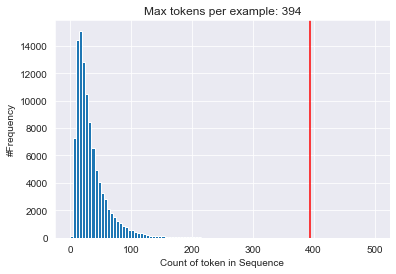

In [4]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)

lengths = []
for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.en.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim(),color="red")
plt.title(f'Max tokens per example: {max_length}')
plt.ylabel("#Frequency")
plt.xlabel("Count of token in Sequence")
plt.show()


### Global static variables for batching

In [5]:
MAX_TOKENS = 128 ### based on above chart
BUFFER_SIZE = 20000
BATCH_SIZE = 128

### Batching dataset

In [6]:
def filter_max_tokens(pt, en):
    num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
    return num_tokens < MAX_TOKENS

def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt.to_tensor()
    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    return pt, en

def generate_batches(dataset):
    return (
      dataset
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))


train_batches = generate_batches(train_examples)
val_batches = generate_batches(val_examples)
test_batches = generate_batches(test_examples)


### Positional embedding

In [7]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

### Maskikng the attentions

In [8]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :] 


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask 

# Attention Implementation

### Attention weights

In [9]:
def scaled_dot_product_attention(q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True) 


        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

        output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

        return output, attention_weights

### Multi-Head Attention

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  
        k = self.wk(k) 
        v = self.wv(v)  

        q = self.split_heads(q, batch_size)  
        k = self.split_heads(k, batch_size) 
        v = self.split_heads(v, batch_size) 


        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  
        output = self.dense(concat_attention)  

        return output, attention_weights

# Transformer Implementations

### Feed forward network

In [11]:
def point_wise_feed_forward_network(d_model, dff):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(dff, activation='relu')) # (batch_size, seq_len, dff)
    model.add(tf.keras.layers.Dense(d_model)) # (batch_size, seq_len, d_model)
    return model 

### Encoder Implementation

In [12]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [13]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x) 
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x 

### Decoder Implementation

In [14]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  

        ffn_output = self.ffn(out2)  
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2) 

        return out3, attn_weights_block1, attn_weights_block2

In [15]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

### Transformer Model Implementation

In [16]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,target_vocab_size, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,num_heads=num_heads, dff=dff,input_vocab_size=input_vocab_size, rate=rate)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,num_heads=num_heads, dff=dff,target_vocab_size=target_vocab_size, rate=rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        inp, tar = inputs
        padding_mask, look_ahead_mask = self.create_masks(inp, tar)
        enc_output = self.encoder(inp, training, padding_mask) 

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, padding_mask)
        final_output = self.final_layer(dec_output)  

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        padding_mask = create_padding_mask(inp)

        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        return padding_mask, look_ahead_mask

# Build models and related functions(loss,optimizer,...) & Train

### Define detail of the network architecture

In [17]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.1
EPOCHS = 20


### Optimizer Implementation

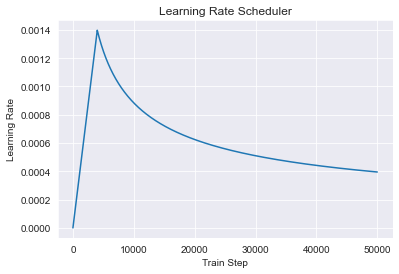

In [18]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)
plt.plot(temp_learning_rate_schedule(tf.range(50000, dtype=tf.float32)))
plt.title("Learning Rate Scheduler")
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

### Loss Implementation

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')



### Build a transformer model

In [20]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

### Train on batch

In [21]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp],training = True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

### Train loop

In [22]:
def train():
    losses = []
    acc = []
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()
        L = 0 
        A = 0
        i = 0
        for (batch, (inp, tar)) in enumerate(train_batches):
            train_step(inp, tar)

            i+=1
            L += train_loss.result()
            A += train_accuracy.result()

            if batch % 50 == 0:
                print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

        losses.append(L/i)
        acc.append(A/i) 

    return losses,acc 

results = train()
        

Epoch 1 Batch 0 Loss 8.8461 Accuracy 0.0004
Epoch 1 Batch 50 Loss 8.7850 Accuracy 0.0153
Epoch 1 Batch 100 Loss 8.6787 Accuracy 0.0309
Epoch 1 Batch 150 Loss 8.5575 Accuracy 0.0363
Epoch 1 Batch 200 Loss 8.4049 Accuracy 0.0407
Epoch 1 Batch 250 Loss 8.2236 Accuracy 0.0457
Epoch 1 Batch 300 Loss 8.0240 Accuracy 0.0544
Epoch 1 Loss 7.9954 Accuracy 0.0558
Time taken for 1 epoch: 58.82 secs

Epoch 2 Batch 0 Loss 6.7568 Accuracy 0.1187
Epoch 2 Batch 50 Loss 6.5608 Accuracy 0.1208
Epoch 2 Batch 100 Loss 6.4127 Accuracy 0.1250
Epoch 2 Batch 150 Loss 6.3041 Accuracy 0.1309
Epoch 2 Batch 200 Loss 6.2113 Accuracy 0.1375
Epoch 2 Batch 250 Loss 6.1189 Accuracy 0.1452
Epoch 2 Batch 300 Loss 6.0284 Accuracy 0.1525
Epoch 2 Loss 6.0249 Accuracy 0.1528
Time taken for 1 epoch: 51.29 secs

Epoch 3 Batch 0 Loss 5.5354 Accuracy 0.1942
Epoch 3 Batch 50 Loss 5.4289 Accuracy 0.1988
Epoch 3 Batch 100 Loss 5.3702 Accuracy 0.2026
Epoch 3 Batch 150 Loss 5.3206 Accuracy 0.2065
Epoch 3 Batch 200 Loss 5.2742 Accurac

### Plot training loss & acc

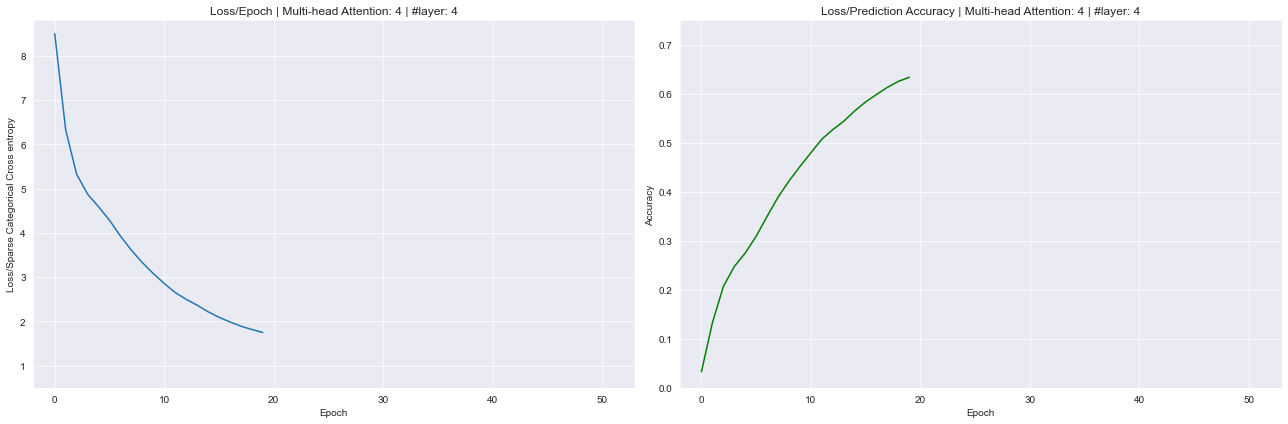

In [23]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (18,6)
plt.subplot(1,2,1)
plt.plot(results[0])
plt.xlabel("Epoch")
plt.xlim((-2,53))
plt.ylim((0.5,8.8))
plt.ylabel("Loss/Sparse Categorical Cross entropy")
plt.title("Loss/Epoch | Multi-head Attention: {0} | #layer: 4".format(num_heads))

plt.subplot(1,2,2)
plt.plot(results[1],color="green")
plt.xlabel("Epoch")
plt.xlim((-2,53))
plt.ylim((0,0.75))
plt.ylabel("Accuracy")
plt.title("Loss/Prediction Accuracy | Multi-head Attention: {0} | #layer: 4".format(num_heads))

plt.tight_layout()
plt.show()

# Translation

In [24]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=MAX_TOKENS):
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

        encoder_input = sentence

        start_end = self.tokenizers.en.tokenize([''])[0]
        start = start_end[0][tf.newaxis]
        end = start_end[1][tf.newaxis]

        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)
        
        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions, _ = self.transformer([encoder_input, output], training=False)
            predictions = predictions[:, -1:, :]  
            predicted_id = tf.argmax(predictions, axis=-1)
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break
            
        output = tf.transpose(output_array.stack())
        text = tokenizers.en.detokenize(output)[0]  # shape: ()
        tokens = tokenizers.en.lookup(output)[0]
        _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)
        return text, tokens, attention_weights

translator = Translator(tokenizers, transformer)

# Attention heatmap and prediction

In [25]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')
    

In [31]:
sentence = """é algo que nos acontece sem o nosso consentimento ."""
ground_truth = """it 's something that happens to us without our consent ."""

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : é algo que nos acontece sem o nosso consentimento .
Prediction     : it ' s something that happens without our consent .
Ground truth   : it 's something that happens to us without our consent .


In [32]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    translated_tokens = translated_tokens[1:]
    ax = plt.gca()
    
    ax.matshow(attention,cmap ="cool")
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))
    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
        labels, rotation=90)
    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)


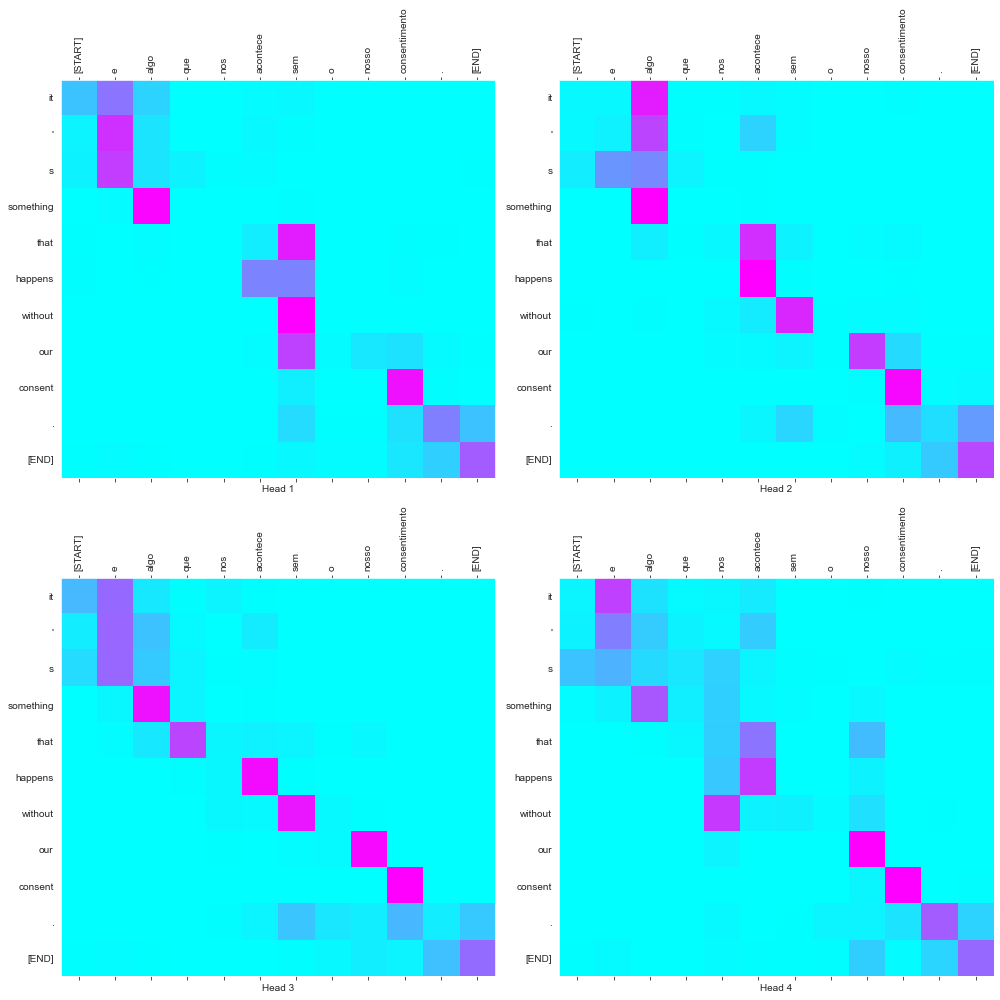

In [33]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
    in_tokens = tokenizers.pt.lookup(in_tokens)[0]
    in_tokens

    fig = plt.figure(figsize=(14, 14))
    
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(num_heads//2, 2, h+1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

sns.set_style("dark")
plot_attention_weights(sentence, translated_tokens,attention_weights['decoder_layer4_block2'][0])

### Sample translation

In [29]:
Index = 1
for test in test_examples.take(50):
    print(f"\nTest Sample #{Index} <==========================")
    pt = test[0].numpy().decode("utf-8")
    en = test[1].numpy().decode("utf-8")
    translated_text, translated_tokens, attention_weights = translator(
        tf.constant(pt))
    print_translation(pt, translated_text, en)
    Index += 1


Test Sample #1 <==========================
Input:         : depois , podem fazer-se e testar-se previsões .
Prediction     : then you can do and test it .
Ground truth   : then , predictions can be made and tested .

Test Sample #2 <==========================
Input:         : forçou a parar múltiplos laboratórios que ofereciam testes brca .
Prediction     : it ' s done multiple laboratories that are paid for braking .
Ground truth   : it had forced multiple labs that were offering brca testing to stop .

Test Sample #3 <==========================
Input:         : as formigas são um exemplo clássico ; as operárias trabalham para as rainhas e vice-versa .
Prediction     : the megas are a classical setting ; the work for the queens and vice versa .
Ground truth   : ants are a classic example ; workers work for queens and queens work for workers .

Test Sample #4 <==========================
Input:         : uma em cada cem crianças no mundo nascem com uma doença cardíaca .
Prediction     